<a href="https://colab.research.google.com/github/e-abtahi/Natural_Language_Processing_Portfolio/blob/main/03_Transformers/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

In the fast-evolving landscape of the entertainment industry, it is important to gauge audience sentiments towards movie releases. Understanding the sentiments expressed in movie reviews is crucial for shaping marketing strategies, refining content creation, and ultimately enhancing the overall viewer experience. However, manually analyzing an extensive volume of reviews is time-consuming and may not capture nuanced sentiments at scale. To address this, we aim to develop an ML-based sentiment analyzer that automatically evaluates movie reviews, providing actionable insights into audience perceptions.

### **Data Dictionary**

- **review:** review of a movie
- **sentiment:** indicates the sentiment of the review ( 0 is for negative review and 1 for positive review)

## **Installing Necessary libraries**

In [1]:
# installing the libraries for transformers
!pip install -U -q sentence-transformers transformers bitsandbytes accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.1 MB/s eta 0:00:00


## **Importing Necessary Libraries**

In [2]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# to split the data
from sklearn.model_selection import train_test_split

# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier


# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## **Importing the dataset**

In [3]:
# to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# loading data into a pandas dataframe
reviews = pd.read_csv("/content/drive/MyDrive/2.2+imdb_10K_sentimnets_reviews.csv")

In [5]:
# creating a copy of the data
data = reviews.copy()

## **Data Overview**

### **Checking the first 5 rows**

In [6]:
data.head(5)

,review,sentiment
0,"Okay, I know this does'nt project India in a good light. But the overall theme of the movie is not India, it's Shakti. The power of a warlord, and the power of a mother. The relationship between Nandini and her husband and son swallow you up in their warmth. Then things go terribly wrong. The interaction between Nandini and her father in law - the power of their dysfunctional relationship - and the lives changed by it are the strengths of this movie. Shah Rukh Khan's performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor. It is easy to get caught up in the love, violence and redemption of lives in this film, and find yourself heaving a sigh of relief and sadness at the climax. The musical interludes are strengths, believable and well done.",1
1,"Despite John Travolta's statements in interviews that this was his favorite role of his career, ""Be Cool"" proves to be a disappointing sequel to 1995's witty and clever ""Get Shorty.""<br /><br />Travolta delivers a pleasant enough performance in this mildly entertaining film, but ultimately the movie falls flat due to an underdeveloped plot, unlikeable characters, and a surprising lack of chemistry between leads Travolta and Uma Thurman. Although there are some laughs, this unfunny dialog example (which appeared frequently in the trailers) kind of says it all: Thurman: Do you dance? Travolta: Hey, I'm from Brooklyn.<br /><br />The film suggests that everyone in the entertainment business is a gangster or aspires to be one, likening it to organized crime. In ""Get Shorty,"" the premise of a gangster ""going legitimate"" by getting into movies was a clever fish-out-of water idea, but in ""Be Cool,"" it seems the biz has entirely gone crooked since then.<br /><br />The film is interestingly casted and the absolute highlight is a ""monolgue"" delivered by The Rock, whose character is an aspiring actor as well as a goon, where he reenacts a scene between Gabrielle Union and Kirsten Dunst from ""Bring It On."" Vince Vaughan's character thinks he's black and he's often seen dressed as a pimp-- this was quite funny in the first scene that introduces him and gets tired and embarrassing almost immediately afterward.<br /><br />Overall, ""Be Cool"" may be worth a rental for John Travolta die-hards (of which I am one), but you may want to keep your finger close to the fast forward button to get through it without feeling that you wasted too much time. Fans of ""Get Shorty"" may actually wish to avoid this, as the sequel is devoid of most things that made that one a winner. I rate this movie an admittedly harsh 4/10.",0
2,"I am a kung fu fan, but not a Woo fan. I have no interest in gangster movies filled with over-the-top gun-play. Now, martial arts; *that's* beautiful! And John Woo surprised me here by producing a highly entertaining kung fu movie, which almost has *too much* fighting, if such a thing is possible! This is good stuff.<br /><br />Many of the fight scenes are very good (and some of them are less good), and the main characters are amusing and likable. The bad guys are a bit too unbelievably evil, but entertaining none the less. You gotta see the Sleeping Wizard!! He can only fight when he's asleep - it's hysterical!<br /><br />Upon repeated viewings, however, Last Hurrah For Chivalry can tend to get a little boring and long-winded, also especially because many of the fight scenes are actually not that good. Hence, I rate it ""only"" a 7 out of 10. But it really is almost an ""8"".<br /><br />All in all one of the better kung fu movies, made smack-dab in the heart of kung fu cinema's prime. All the really good kung fu movies are from the mid- to late 1970ies, with some notable exceptions from the late '60ies and early '70ies (and early '80ies, to be fair).",1
3,"He seems to be a control freak. I have heard him comment on ""losing control of the show"" and tell another guest who brought live animals that he had one rule-""n

* Here, a sentiment value of **0 is negative** and **1 is positive**.

### **Checking the shape of the data**

In [7]:
data.shape

(10000, 2)

* The dataset has 10000 rows and 2 columns.

### **Checking for missing values**

In [8]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

* There are no missing values in the data

### **Checking for duplicate values**

In [9]:
# checking for duplicate values
data.duplicated().sum()

18

In [10]:
# keeping only the first occurence of duplicate values and dropping the rest
data = data.drop_duplicates(keep = 'first')

In [11]:
# reseting the index of the dataframe
data = data.reset_index(drop = True)

### **Checking the distribution of sentiments**

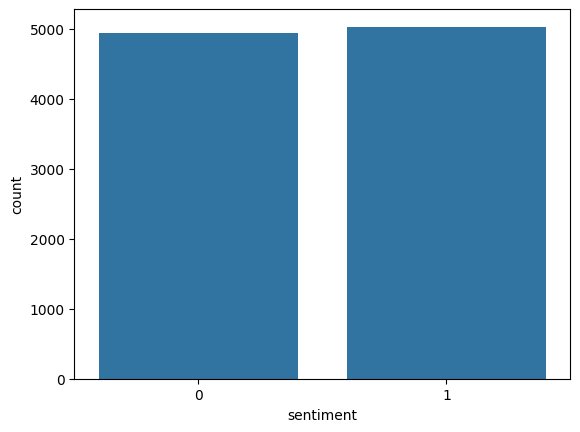

In [12]:
sns.countplot(data=data, x='sentiment');

- There are almost an equal number of positive and negative reviews.

## **Semantic Search**

### **Defining the model**

We'll be using the **all-MiniLM-L6-v2** model here.

💡 The **all-MiniLM-L6-v2** model is an all-round (**all**) model trained on a large and diverse dataset of over 1 billion training samples and generates state-of-the-art sentence embeddings of 384 dimensions.

📊  It is a language model (**LM**) that has 6 transformer encoder layers (**L6**) and is a smaller model (**Mini**) trained to mimic the performance of a larger model (BERT).

🛠️ Potential use-cases include text classification, sentiment analysis, and semantic search.

In [13]:
# defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# there are many other models to choose from too!
# https://www.sbert.net/docs/pretrained_models.html
# https://huggingface.co/spaces/mteb/leaderboard
# model = SentenceTransformer('BAAI/bge-base-en-v1.5')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

### **Basic Examples**

In [14]:
model.encode(['hello, my name is Dan!'])

array([[-1.20215982e-01,  2.33266745e-02,  7.85414726e-02,
         1.16624637e-02, -1.03290036e-01, -7.39679113e-02,
         1.02147274e-01, -6.54307287e-03,  3.59935910e-02,
        -3.56885642e-02, -1.05193347e-01, -3.54266614e-02,
         5.80283925e-02, -3.58375460e-02, -1.06713548e-02,
        -7.68467411e-02, -1.83965103e-03,  7.92892277e-02,
        -1.11362427e-01,  1.66799705e-02,  1.89157855e-02,
         5.40749952e-02, -1.14753973e-02, -7.31310770e-02,
        -2.53050551e-02,  2.23015132e-03,  1.27340723e-02,
         7.92560056e-02, -5.07033244e-02, -9.75874662e-02,
         5.82299791e-02,  8.89130905e-02, -9.72990703e-04,
         7.41752312e-02, -4.20287922e-02, -7.49425963e-03,
        -8.95282850e-02, -1.63527438e-03,  2.08540056e-02,
         4.06790152e-02, -8.82210769e-03, -5.00588194e-02,
         2.89774388e-02, -2.87493039e-02,  1.48246186e-02,
         8.40839446e-02, -1.15908720e-02,  5.21295741e-02,
         1.06916994e-01, -2.68502184e-03, -7.66271874e-0

In [15]:
model.encode(['hello, my name is Dan?'])

array([[-1.25161678e-01,  1.75925437e-02,  8.88532102e-02,
         1.19403154e-02, -1.01614460e-01, -8.46365541e-02,
         1.51050657e-01,  1.13875242e-02,  3.35772000e-02,
        -6.02389090e-02, -9.43934768e-02, -6.10976480e-02,
         3.05960365e-02, -3.64653617e-02,  2.23343093e-02,
        -6.00001700e-02, -1.09070325e-02,  4.52446491e-02,
        -1.35518461e-01,  8.65479838e-03, -3.05692572e-02,
         4.97333892e-02, -2.62118876e-03, -8.41946676e-02,
        -1.79406833e-02,  7.51870126e-03,  4.12367806e-02,
         8.72903913e-02, -4.14225981e-02, -9.46632698e-02,
         5.46788983e-02,  7.33749717e-02,  9.49008204e-03,
         5.40020876e-02, -3.70322540e-02, -2.95581878e-03,
        -7.40623772e-02, -2.60347174e-03,  2.09947117e-02,
         4.12505344e-02, -1.53503371e-02, -5.49956895e-02,
         3.44849862e-02, -3.37540507e-02,  2.53537446e-02,
         5.75930364e-02, -1.41589409e-02,  3.40199806e-02,
         9.93730873e-02, -2.64637806e-02, -9.78996754e-0

In [16]:
# defining a function to compute the cosine similarity between two embedding vectors
def cosine_score(text):
    # encoding the text
    embeddings = model.encode(text)

    # calculating the L2 norm of the embedding vector
    norm1 = np.linalg.norm(embeddings[0])
    norm2 = np.linalg.norm(embeddings[1])

    # computing the cosine similarity
    cosine_similarity_score = ((np.dot(embeddings[0],embeddings[1]))/(norm1*norm2))

    return cosine_similarity_score

In [17]:
sentence_1 = "The cat is on the mat."
sentence_2 = "The mat has a cat on it."

cosine_score([sentence_1, sentence_2])

0.9624443

- The **high cosine similarity score** indicates that the sentences are **semantically similar**.


In [18]:
sentence_1 = "Roses are red, violets are blue."
sentence_2 = "The Earth orbits the Sun in our solar system."

cosine_score([sentence_1, sentence_2])

0.12664361

- The **low cosine similarity score** indicates that the sentences are **semantically dissimilar**.

In [19]:
sentence_1 = "My name is Mark and I love football."
sentence_2 = "A strange object was found in the Mariana Trench."

cosine_score([sentence_1, sentence_2])

-0.061561085

- The **lower cosine similarity score** indicates that the sentences are even more **semantically dissimilar**.


### **Encoding the dataset**

In [20]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# encoding the dataset
embedding_matrix = model.encode(data['review'], device=device, show_progress_bar=True)

Batches:   0%|          | 0/312 [00:00<?, ?it/s]

In [22]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(9982, 384)

In [23]:
# printing the embedding vector of the first review in the dataset
embedding_matrix[0,:]

array([-7.45214298e-02,  2.59446609e-03, -3.34988758e-02, -4.84162681e-02,
       -3.84775884e-02,  6.37952760e-02,  5.54267736e-03,  4.06936817e-02,
        6.29823431e-02, -3.84879708e-02, -1.27105266e-02, -2.12659724e-02,
        6.79038689e-02,  2.27344735e-03,  1.14874984e-03,  2.30603609e-02,
        8.18004981e-02,  4.14929204e-02, -2.12946627e-02, -2.29654480e-02,
        2.09020562e-02, -2.93924734e-02,  9.37751383e-02, -2.93005425e-02,
       -6.34454563e-02, -1.70642566e-02,  1.12413347e-01, -2.24412009e-02,
       -6.00713901e-02,  1.55951865e-02,  2.08700635e-02,  7.55285919e-02,
       -6.04214780e-02,  2.33686925e-03, -1.79052539e-02,  7.56649002e-02,
        9.78594553e-03,  2.67771762e-02, -1.30182598e-02, -1.76513679e-02,
        3.84344943e-02,  3.93548273e-02,  5.56519888e-02, -1.35074668e-02,
        5.03628105e-02, -7.22084343e-02, -2.37328783e-02, -1.08479768e-01,
        2.67261118e-02, -5.05364686e-02, -8.09638277e-02,  5.58140464e-02,
       -1.44369155e-03, -

### **Querying from the dataset**

**Now, let's search for similar reviews in our dataset.**

In [24]:
# defining a function to find the top k similar sentences for a given query
def top_k_similar_sentences(embedding_matrix,query_text,k):
    # encoding the query text
    query_embedding = model.encode(query_text)

    # calculating the cosine similarity between the query vector and all other encoded vectors of our dataset
    score_vector = np.dot(embedding_matrix,query_embedding)

    # sorting the scores in descending order and choosing the first k
    top_k_indices = np.argsort(score_vector)[::-1][:k]

    # returning the corresponding reviews
    return data.loc[list(top_k_indices), 'review']

In [25]:
# defining the query text
query_text = "Horror movies"

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,5)

for i in top_k_reviews:
    print(i, end="\n\n")

I have just recently been through a stage where I wanted to see why it is that horror films of the 90's can't hold a candle to 70's and 80's horror films. I have been very public in this forum about the vileness of films like The Haunting and Urban Legend and such. I feel that they (and others like them) don't know what true horror is. And it bothered me to the point where it made me go to my local video store and rent some of the classic horror films. I already own all the Friday's so I rented The Texas Chainsaw Massacre, the original Nightmare On Elm Street, Jaws, The Exorcist, Angel Heart, The Exorcist and Halloween. Now the other films are classics in their own right but it is here that I want to tell you about Halloween. Because what Halloween does is perhaps something no other film in the history of horror film can do, and that is it uses subtle techniques, techniques that don't rely on blood and gore, and it uses these to scare the living daylights out of you. I was in a room by

In [26]:
# defining the query text
query_text = "Action movie with lots of car chases"

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,5)

for i in top_k_reviews:
    print(i, end="\n\n")

I think the filmographic lineage may run like this. Pay attention, please, because I had to look this up. In 1967 Peter Yates, an ex auto racer, directs the English caper movie "Robbery," the most thrilling part of which is a car chase through the streets of London, down alleys where there are crowds of children playing and all that. It's a success.<br /><br />A year later, Yates directs "Bullet", starring Steve McCool, I mean McQueen, featuring another even more spectacular car chase up and down the San Francisco Hills, with dumbfoundingly authentic engine sounds that seem to include double clutching, full race cams, no mufflers, twelve-cylinder engines under forty-foot hoods, supercharged, superdupercharged, and all five-thousand horsepower running at full tilt. Lots of shots of McQueen's gum-chewing visage scowling with concentration as he tries to bump another car off the highway, though a passenger in the other vehicle totes a shotgun. The chase is staged by Philip D'Antoni. Bill 

In [27]:
# defining the query text
query_text = "The movie wasn't great but it delivered as per the expectations."

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,5)

for i in top_k_reviews:
    print(i, end="\n\n")

This movie turned out to be better than I had expected it to be. Some parts were pretty funny. It was nice to have a movie with a new plot.

I didnt know what to expect . I only watched it on a rainy sunday afternoon on pay tv . Right from the start it drew me in . The music and settings and characters were excellent . I hadnt heard of any of the actors but they all were outstanding . A wonderful thriller .<br /><br />Now that ive read other comments on this movie referring to past versions and the book , i will be endeavouring to find out more on this great movie

Considering the big name cast and lavish production I expected a lot more of this film. The acting for the most part is great, although the story they have to work with is mediocre at best. However the film still warrants watching because of the acting and the stars and some and up and coming young talent.

I really didn't have high expectations and I must admit that I wasn't disappointed. This movie is so terrible that I fe

### **Categorization of Reviews**

- Let's try categorizing some of the reviews based on queries that can act as category identifiers.

- We'll choose
    - one highly positive query
    - one moderately positive query
    - one highly negative query
    - one moderately negative query

In [28]:
# queries acting as catergory identifiers
queries_for_categorization = [
    "Overall a great movie that ticks all the right boxes.",
    "The movie wasn't that great but it delivered as per the expectations.",
    "The movie was a bad experience with bad direction and poor story.",
    "The plot was confusing but the acting performances were okay. The movie was mediocre at best."
]

**Now, we'll use the model to identify movie reviews that are most similar to the above queries.**

In [29]:
# dictionary to store the reviews for each of the categories
categorized_reviews = {}

# number of reviews to consider for similarity
k = 500

# looping over the queries and updating the values to the top review sentences similar to the queries
for query in queries_for_categorization:
    categorized_reviews[query] = top_k_similar_sentences(embedding_matrix, query, k)

**Let's check the results.**

In [30]:
i = 0
print('Query Text:', queries_for_categorization[i], end='\n')
print('Similar Reviews:', end='\n\n')
categorized_reviews[queries_for_categorization[i]].head(10)

Query Text: Overall a great movie that ticks all the right boxes.
Similar Reviews:



6502                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         wonderful movie with good story great humour (some great one-liners) and a soundtrack to die for.<br /><br />i've seen it 3 times so far.<br /><br />the american audiences are going to love it.
8376                                                                                  <br /><br />When I first heard about this back in 1997, over coffee with friends, I decided to check it out. The only problem was that it was on a small screen at one of my local cinema's.<br /><br />That didn't stop the enjoym

In [31]:
i = 1
print('Query Text:', queries_for_categorization[i], end='\n')
print('Similar Reviews:', end='\n\n')
categorized_reviews[queries_for_categorization[i]].head(10)

Query Text: The movie wasn't that great but it delivered as per the expectations.
Similar Reviews:



1739                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [32]:
i = 2
print('Query Text:', queries_for_categorization[i], end='\n')
print('Similar Reviews:', end='\n\n')
categorized_reviews[queries_for_categorization[i]].head(10)

Query Text: The movie was a bad experience with bad direction and poor story.
Similar Reviews:



1327                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [33]:
i = 3
print('Query Text:', queries_for_categorization[i], end='\n')
print('Similar Reviews:', end='\n\n')
categorized_reviews[queries_for_categorization[i]].head(10)

Query Text: The plot was confusing but the acting performances were okay. The movie was mediocre at best.
Similar Reviews:



1833                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       The plot is tight. The acting is flawless. The directing, script, scenery, casting are all well done. I watch

**Important Note**
1. It is important to note that we loaded a pre-trained model.
2. As the model was not trained or fine-tuned on this data, the performance may not be excellent.
3. As we are doing semantic search and not clustering, there may be reviews that fall in multiple categories.

## **Sentiment Analysis**

Like the previous session, we can build a random forrest classifier!

In [34]:
# Process the data

X = embedding_matrix
y = data["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
# build a RF model

# Building the model
rf_transformer = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)

# Fitting on train data
rf_transformer.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=42)

In [36]:
# Predicting on train data
y_pred_train = rf_transformer.predict(X_train)

# Predicting on test data
y_pred_test = rf_transformer.predict(X_test)

In [37]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = [0, 1]
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

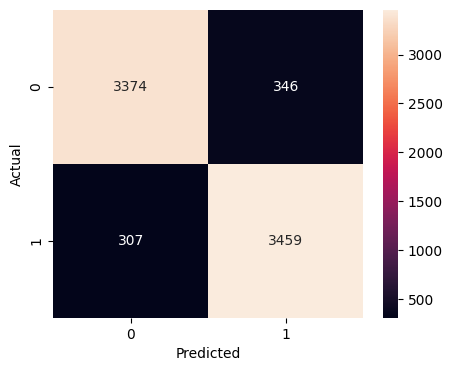

In [38]:
plot_confusion_matrix(y_train, y_pred_train)

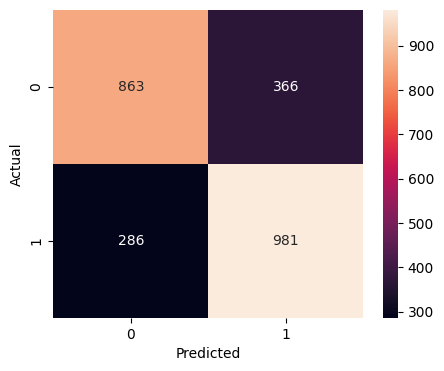

In [39]:
plot_confusion_matrix(y_test, y_pred_test)

### We can also use a pre-trained model!

In [40]:
sentiment_hf = pipeline("sentiment-analysis") # this uses the HF default sentiment analysis model

# you can choose to use any other model by including a model argument like:
# sentiment_hf = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
# or
# nlptown/bert-base-multilingual-uncased-sentiment
# many more models can be found at https://huggingface.co/models?pipeline_tag=text-classification&sort=trending&search=sentiment
# these are all text-classification models...sentiment analysis is a special case of text classification

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [41]:

trial_data = ["I love this movie", "This movie is not very good at all!",'There is a cat outside.']
sentiment_hf(trial_data)

[{'label': 'POSITIVE', 'score': 0.9998766183853149},
 {'label': 'NEGATIVE', 'score': 0.9998003840446472},
 {'label': 'NEGATIVE', 'score': 0.6246485710144043}]

In [ ]:
hf_review_dict = sentiment_hf(data['review'].to_list(),truncation=True) # very long reviews will be truncated to 512 tokens...which isn't great!

In [ ]:
hf_review_sent = [0]*len(data['review'])
for movie in range(len(data['review'])):
  if hf_review_dict[movie]['label']=='POSITIVE':
    hf_review_sent[movie] = 1

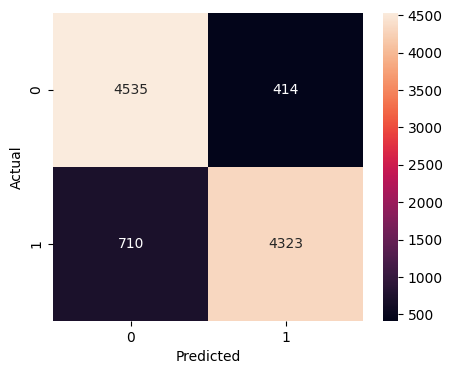

In [ ]:
plot_confusion_matrix(y, hf_review_sent)

### **We could also use an LLM to ask about sentiment!**

#### **Defining the input and target variables**

In [ ]:
X = data['review']
y = data["sentiment"]

### **Defining the Model**

We'll be using the **Google FLAN-T5** model here.

💡 **FLAN-T5, developed by Google Research, is a "Fine-tuned LAnguage Net" (FLAN) with "Text-To-Text Transfer Transformer" (T-5) architecture.**

📊 **FLAN-T5 excels in various NLP tasks**, including translation, classification, and question answering, and it's known for its speed and efficiency.

📋 FLAN-T5 comes in different sizes: small, base, large, XL, and XXL, offering customization options.

🛠️ Potential use-cases include text generation, classification, summarization, sentiment analysis, question-answering, translation, and chatbots.

In [43]:
# initializing a T5 tokenizer using the pre-trained model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
# initializing a T5 model for conditional generation using the pre-trained model "google/flan-t5-large"
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", load_in_8bit=True, device_map="auto")

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

- We have loaded the model in 8-bit quantized format for efficiency and lower memory usage.
- We have set the device mapping to "auto" for automatic device assignment.
    - This will automatically detect available GPUs and use it.

In [45]:
# defining a function to generate, process, and return a response
def generate_response(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")    ### using the tokenizer to create tokens in tensor format from an input
    outputs = model.generate(input_ids, max_length=16, do_sample=True, temperature=0.001)    ### generating the model output in tensor format
    return tokenizer.decode(outputs[0])[6:-4]    ### using the tokenizer to decode the model output, and then return it

In the `generate()` function defined above, the following arguments were used:

1. `max_length`: This parameter determines the maximum length of the generated sequence. In the provided code, max_length is set to 300, which means the generated sequence should not exceed 300 tokens.

2. `temperature`: The temperature parameter controls the level of randomness in the generation process. A higher temperature (e.g., closer to 1) makes the output more diverse and creative but potentially less focused, while a lower temperature (e.g., close to 0) produces more deterministic and focused but potentially repetitive outputs. In the code, temperature is set to 0.001, indicating a very low temperature and, consequently, a more deterministic sampling.

3. `do_sample`: This is a boolean parameter that determines whether to use sampling during generation (do_sample=True) or use greedy decoding (do_sample=False). When set to True, as in the provided code, the model samples from the distribution of predicted tokens at each step, introducing randomness in the generation process.

### **Model Predictions**

In [46]:
# checking a customer review and it's sentiment
print('Review:\t', X[4])
print('Actual Sentiment:\t', y[4])

Review:	 [-9.16919708e-02 -5.20093180e-02  1.09418528e-02 -3.08951531e-02
 -9.35629383e-03  4.81232107e-02  2.70113684e-02  2.63061114e-02
  4.29064743e-02  2.42752042e-02  1.04384022e-02  2.25789584e-02
  5.71161546e-02  2.92078648e-02 -3.36924791e-02 -4.25323583e-02
  1.68710664e-01  1.37007916e-02 -7.55678490e-02  6.77216500e-02
  2.37206481e-02 -4.68319245e-02  2.18092240e-02 -1.77991837e-02
 -2.72552166e-02 -1.39143884e-01  1.91599131e-02 -1.29910624e-02
 -7.31567815e-02  1.82647910e-02  5.29893627e-03  7.29685649e-02
 -5.44281490e-02 -3.71744335e-02  2.68999636e-02  3.59078571e-02
  4.16888073e-02  1.90347811e-04 -9.82569531e-02  3.23593169e-02
 -6.77874759e-02 -5.95094264e-02 -1.49062173e-02 -1.75021384e-02
  2.18269452e-02 -5.45420647e-02  4.66980785e-02 -1.11754648e-01
  1.24826040e-02 -7.89609030e-02 -1.17757715e-01  6.53088316e-02
  4.51819338e-02 -3.11714802e-02 -2.79838406e-02 -2.46290006e-02
  3.00444011e-02  6.56499248e-03  4.57153693e-02 -1.24288667e-02
  2.37970669e-02

In [47]:
# defining a prompt which tells the model what to do
sys_prompt = """
    Categorize the sentiment of the review as positive or negative.
    Return 1 for positive and 0 for negative.
"""

# predicting the sentiment using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        Review text: '{}'
    """.format(sys_prompt, X[4])
)

print(pred_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (3356 > 512). Running this sequence through the model will result in indexing errors


0


- The model was able to correctly identify the sentiment here.

**Note**: We'll discuss more about prompts, types of prompts, and how to effectively write them to optimize model outputs in upcoming classes.

In [48]:
# defining a function to generate a sentiment prediction
def predict_sentiment(review_text):
    pred = generate_response(
        """
            {}
            Review text: '{}'
        """.format(sys_prompt, review_text)
    )

    return pred

In [ ]:
# making predictions with the model
predicted_sentiment = [int(predict_sentiment(X[item])[0]) for item in range(len(X))]
# must be careful with an LLM. It just gives you what it 'thinks' you want, which may not be what you actually want
# it's not uncommon for the returned value to not match the format you ask for!
# for example, several times predict_sentiment has returned '1 for positive' instead of just 1!
# that's why I grab the 0th entry from the returned string!

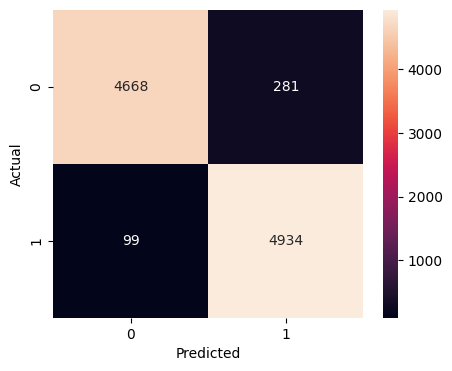

In [ ]:
plot_confusion_matrix(y, predicted_sentiment)

## **Conclusion**

- We used the ***all-MiniLM-L6-v2*** model to do semantic search.
    - We first encoded the dataset using the model to generate embeddings of 384 dimensions.
    - Then we queried the dataset to find movie reviews similar to the query text we passed.
    - Finally, we categorized the movie reviews using queries that acted as category identifiers.

- We trained a Random Forrest model to do sentiment analysis based on the output of ***all-MiniLM-L6-v2***

- We used the ***sentiment analysis*** pipeline from huggingface to analyze the sentiment of all the movie reviews

- We used the ***Google FLAN-T5*** model to do sentiment analysis.
    - We first created a function that would take the input data, tokenize it, pass the tokenized data to the model for predictions, process the model output, and then return a response.
    - We then defined a prompt to tell the model what exactly it has to do.
    - We then made predictions with the model using the function and the prompt.